In [1]:
!pip install tensorflow optuna matplotlib scikit-learn


In [45]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist # Modificado para carregar o Fashion-MNIST
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

# Carregando o dataset Fashion-MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data() # Modificado aqui

# Normalizando os dados para o intervalo [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Achatar as imagens para vetores de 28*28 = 784 elementos
x_train = x_train.reshape((len(x_train), -1))
x_test = x_test.reshape((len(x_test), -1))

# Vamos imprimir as dimensões para verificar se está correto
print(x_train.shape, x_test.shape)


4422102/4422102 [==============================] - 0s 0us/step
(60000, 784) (10000, 784)


In [46]:
def build_vae(input_shape, latent_dim, intermediate_dims):
    # Encoder
    inputs = Input(shape=input_shape, name='encoder_input')
    x = inputs
    for intermediate_dim in intermediate_dims:
        x = Dense(intermediate_dim, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)


    # Função para amostrar do espaço latente
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # Encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    
    # Decoder
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = latent_inputs
    for intermediate_dim in reversed(intermediate_dims):
        x = Dense(intermediate_dim, activation='relu')(x)
    outputs = Dense(input_shape[0], activation='sigmoid')(x)

    # Decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')

    # VAE model
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='vae_mlp')

    # VAE loss
    reconstruction_loss = binary_crossentropy(inputs, outputs) * input_shape[0]
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')

    return encoder, decoder, vae

# Criando o VAE
encoder, decoder, vae = build_vae((784,), latent_dim=20, intermediate_dims=[256])


# Resumo do modelo
encoder.summary()
decoder.summary()
vae.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 784)]                0         []                            
                                                                                                  
 dense_37 (Dense)            (None, 256)                  200960    ['encoder_input[0][0]']       
                                                                                                  
 z_mean (Dense)              (None, 20)                   5140      ['dense_37[0][0]']            
                                                                                                  
 z_log_var (Dense)           (None, 20)                   5140      ['dense_37[0][0]']            
                                                                                            

 tf.math.reduce_mean_23 (TF  ()                           0         ['tf.__operators__.add_23[0][0
 OpLambda)                                                          ]']                           
                                                                                                  
 add_loss_11 (AddLoss)       ()                           0         ['tf.math.reduce_mean_23[0][0]
                                                                    ']                            
                                                                                                  
Total params: 418104 (1.59 MB)
Trainable params: 418104 (1.59 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________


In [47]:
#Treinamento VAE Simples para testar

# Parâmetros de treinamento
epochs = 15  # Pode ajustar conforme necessário
batch_size = 256  # Pode ajustar conforme necessário

# Treinamento do modelo
vae.fit(x_train, x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))


Epoch 1/15
235/235 [==============================] - 4s 14ms/step - loss: 310.7603 - val_loss: 272.5931
Epoch 2/15
235/235 [==============================] - 4s 15ms/step - loss: 265.1920 - val_loss: 261.6340
Epoch 3/15
235/235 [==============================] - 3s 15ms/step - loss: 257.9035 - val_loss: 256.9296
Epoch 4/15
235/235 [==============================] - 3s 15ms/step - loss: 253.9826 - val_loss: 254.0222
Epoch 5/15
235/235 [==============================] - 4s 15ms/step - loss: 251.4838 - val_loss: 251.6511
Epoch 6/15
235/235 [==============================] - 4s 16ms/step - loss: 249.7207 - val_loss: 250.4344
Epoch 7/15
235/235 [==============================] - 4s 16ms/step - loss: 248.4881 - val_loss: 249.2201
Epoch 8/15
235/235 [==============================] - 4s 16ms/step - loss: 247.5138 - val_loss: 248.5256
Epoch 9/15
235/235 [==============================] - 4s 16ms/step - loss: 246.7213 - val_loss: 248.0253
Epoch 10/15
235/235 [==============================] - 

79/79 [==============================] - 0s 3ms/step


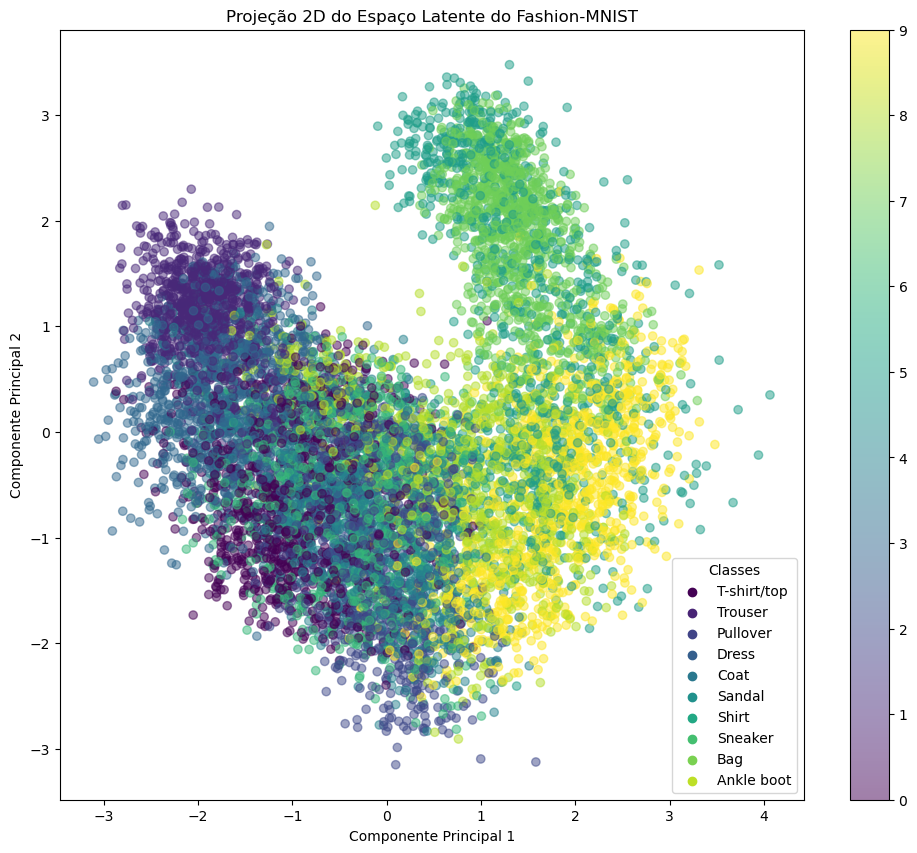

In [51]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Definir o tamanho do lote para previsão
batch_size = 128  # ou outro valor que tenha sido otimizado

# Obtendo as representações latentes
z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)

# Usando PCA para reduzir a dimensionalidade para 2D
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_mean)

# Plotando a projeção do espaço latente
plt.figure(figsize=(12, 10))

# Mapeamento de rótulos numéricos para os nomes das classes
labels_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# Convertendo os rótulos numéricos em nomes de classes
label_names = np.vectorize(labels_map.get)(y_test)

scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=y_test, alpha=0.5, cmap='viridis')
plt.colorbar(scatter)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Projeção 2D do Espaço Latente do Fashion-MNIST')

# Adicionando legendas com os nomes das classes
for i, label in labels_map.items():
    plt.scatter([], [], label=label, color=plt.cm.viridis(i / 10))

plt.legend(title='Classes')
plt.show()


In [36]:
import optuna
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate
from tqdm.auto import tqdm

# Definindo a função de objetivo do VAE para o Optuna
def vae_objective(trial):
    # Hiperparâmetros do Optuna
    num_layers = trial.suggest_int('num_layers', 1, 4)
    latent_dim = trial.suggest_int('latent_dim', 1, 20)
    intermediate_dims = [trial.suggest_int(f'intermediate_dim_{i}', 128, 1024, log=True) for i in range(num_layers)]
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256, 512])
    epochs = 30  # Pode ser fixo ou também otimizado pelo Optuna

    # Construção do modelo VAE com os hiperparâmetros sugeridos
    encoder, decoder, vae = build_vae((784,), latent_dim=latent_dim, intermediate_dims=intermediate_dims)
    
    # Treinamento do modelo
    history = vae.fit(x_train, x_train,
                      epochs=epochs,
                      batch_size=batch_size,
                      validation_data=(x_test, x_test),
                      verbose=0)  # verbose=0 para não imprimir o progresso

    # Retorna a última perda de validação
    val_loss = history.history['val_loss'][-1]
    return val_loss

# Definindo um nome para o estudo e habilitando o progress bar
study_name = 'mnist_vae_optimization'  # Nome do estudo
study = optuna.create_study(direction='minimize', study_name=study_name)

# Callback para acompanhar o progresso
def print_progress(study, trial):
    last_value = trial.value if trial.value is not None else float('nan')
    print(f"Trial {trial.number}: val_loss = {last_value:.3f}, params = {trial.params}")

# Função de progresso personalizada
def optuna_progress_bar(study, trial):
    bar.update(1)

# Inicializando o progress bar
bar = tqdm(total=30, desc=study_name)

# Otimizando com progress bar e print callback
study.optimize(vae_objective, n_trials=30, callbacks=[print_progress, optuna_progress_bar])

# Fechando o progress bar
bar.close()

# Mostrar os melhores hiperparâmetros
print(f"Melhores hiperparâmetros: {study.best_params}")




[I 2023-12-01 16:28:42,903] A new study created in memory with name: mnist_vae_optimization


mnist_vae_optimization:   0%|          | 0/30 [00:00<?, ?it/s]

[W 2023-12-01 16:29:33,674] Trial 0 failed with parameters: {'num_layers': 3, 'latent_dim': 18, 'intermediate_dim_0': 148, 'intermediate_dim_1': 699, 'intermediate_dim_2': 685, 'batch_size': 512} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\ealbvit\AppData\Local\anaconda3\envs\redes_neurais\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\ealbvit\AppData\Local\Temp\ipykernel_6572\639445728.py", line 18, in vae_objective
    history = vae.fit(x_train, x_train,
  File "C:\Users\ealbvit\AppData\Local\anaconda3\envs\redes_neurais\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "C:\Users\ealbvit\AppData\Local\anaconda3\envs\redes_neurais\lib\site-packages\keras\src\engine\training.py", line 1742, in fit
    tmp_logs = self.train_function(iterator)
  File "C:\Users\ealbvit\AppData\Local\anaco

KeyboardInterrupt: 

In [24]:
!pip install plotly

import plotly
print(plotly.__version__)


5.18.0


In [25]:
#Usando o modo offline do ploty, ja que o outro nao funcinou.

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [26]:
!pip install "notebook>=5.3" "ipywidgets>=7.2"
!jupyter nbextension enable --py widgetsnbextension


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [27]:
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate
import plotly
# Certifique-se de que 'study' ainda é o objeto de estudo do Optuna que foi criado e usado anteriormente.

# Plotando a história da otimização
fig1 = plot_optimization_history(study)
fig1.show()

# Plotando coordenadas paralelas dos hiperparâmetros
fig2 = plot_parallel_coordinate(study)
fig2.show()


In [28]:
#Salvar estudo Optune
import joblib

joblib.dump(study, 'study.pkl')


['study.pkl']

Epoch 1/15
938/938 [==============================] - 9s 9ms/step - loss: 153.0199
Epoch 2/15
938/938 [==============================] - 11s 11ms/step - loss: 118.2493
Epoch 3/15
938/938 [==============================] - 10s 11ms/step - loss: 111.9188
Epoch 4/15
938/938 [==============================] - 10s 11ms/step - loss: 109.0041
Epoch 5/15
938/938 [==============================] - 10s 11ms/step - loss: 107.0666
Epoch 6/15
938/938 [==============================] - 10s 11ms/step - loss: 105.7792
Epoch 7/15
938/938 [==============================] - 10s 11ms/step - loss: 104.8777
Epoch 8/15
938/938 [==============================] - 11s 12ms/step - loss: 104.0317
Epoch 9/15
938/938 [==============================] - 11s 12ms/step - loss: 103.4300
Epoch 10/15
938/938 [==============================] - 11s 12ms/step - loss: 102.9232
Epoch 11/15
938/938 [==============================] - 11s 12ms/step - loss: 102.4477
Epoch 12/15
938/938 [==============================] - 11s 12ms/s

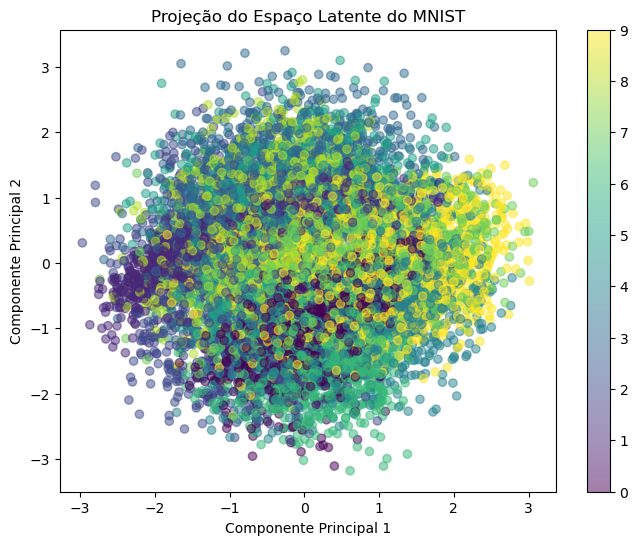

In [8]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# 1. Construir o modelo VAE com os melhores hiperparâmetros
best_params = study.best_params

# Extraindo o número de camadas e as dimensões intermediárias
num_layers = best_params['num_layers']
intermediate_dims = [best_params[f'intermediate_dim_{i}'] for i in range(num_layers)]

encoder, decoder, vae = build_vae(
    input_shape=(784,), 
    latent_dim=best_params['latent_dim'], 
    intermediate_dims=intermediate_dims
)



# 2. Treinar modelo com o conjunto de dados completo
# (assumindo que você tem x_train e x_test já carregados e pré-processados)
vae.fit(x_train, x_train, epochs=15, batch_size=best_params['batch_size'])

# 3. Projeção do espaço latente em 2D
z_mean, _, _ = encoder.predict(x_test, batch_size=best_params['batch_size'])
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_mean)
plt.figure(figsize=(8, 6))
plt.scatter(z_pca[:, 0], z_pca[:, 1], c=y_test, alpha=0.5, cmap='viridis')
plt.colorbar()
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Projeção do Espaço Latente do MNIST')
plt.show()

# 4. Avaliar a rede (opcional e não convencional para VAE)
# Calcule a taxa de acerto se aplicável



1/1 [==============================] - 0s 24ms/step


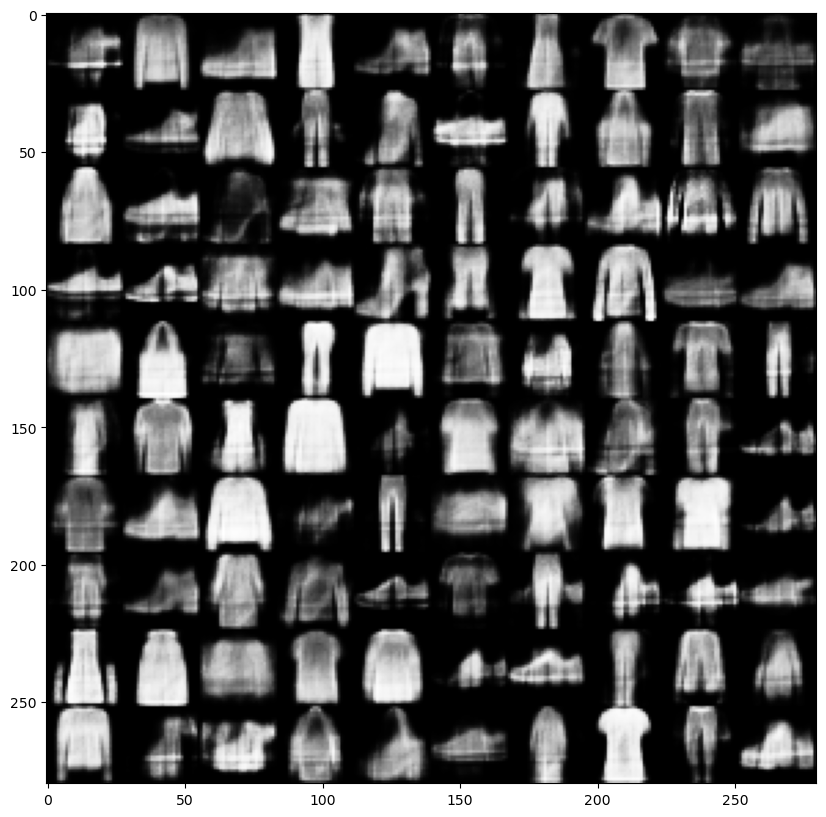

In [50]:
n = 10  # número de dígitos para gerar
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))


#latent_dim = best_params['latent_dim']
latent_dim = 20

# Amostra aleatória de pontos no espaço latente
# Assegurando que cada ponto z_sample tenha a dimensão correta
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        # Aqui nós criamos um vetor latente com a dimensão correta
        z_sample = np.random.normal(size=(1, latent_dim))
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.grid(False)
plt.show()


In [7]:
import joblib

# Carregar estudo do Optuna
study = joblib.load('study.pkl')


In [12]:
##Melhores hiperparâmetros: {'num_layers': 2, 'latent_dim': 17, 'intermediate_dim_0': 1007, 'intermediate_dim_1': 397, 'batch_size': 256}